# CS412 - Machine Learning - 2024-2025
## Homework 4


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

Build a gender classifier using the PyTorch library and a pretrained VGG-16 model on the CelebA dataset. Your goal is to complete the given code without changing the base architecture of VGG-16 (other than replacing the classification head suitable for binary classification).

You will:
- Freeze the convolutional layers of the pretrained model  
- Replace the classifier head with your own binary classification layer  
- Fine-tune the model on the given subset of CelebA  
- Experiment with different values of learning rate, batch size, and number of epochs  

**Dataset:** CelebA  
**Model:** VGG-16
**Library:** PyTorch  

---

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.

##1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [1]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Import necessary libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # Bu satırı ekledik

from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [4]:
data = pd.read_csv('/content/drive/My Drive/CelebA30k.csv') # enter the file path on your drive for the csv file
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
gender_data = data[['filename', 'Male']].copy()
gender_data.head()

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [6]:
# This will extract the contents of the zip file into a folder named data
# Do not extract the zip into your google drive

!unzip "/content/drive/My Drive/CelebA30k.zip" -d "/content/data"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/data/CelebA30k/027646.jpg  
  inflating: /content/data/CelebA30k/007596.jpg  
  inflating: /content/data/CelebA30k/028575.jpg  
  inflating: /content/data/CelebA30k/024367.jpg  
  inflating: /content/data/CelebA30k/023408.jpg  
  inflating: /content/data/CelebA30k/022716.jpg  
  inflating: /content/data/CelebA30k/025079.jpg  
  inflating: /content/data/CelebA30k/003900.jpg  
  inflating: /content/data/CelebA30k/017975.jpg  
  inflating: /content/data/CelebA30k/029643.jpg  
  inflating: /content/data/CelebA30k/026570.jpg  
  inflating: /content/data/CelebA30k/009593.jpg  
  inflating: /content/data/CelebA30k/019780.jpg  
  inflating: /content/data/CelebA30k/008855.jpg  
  inflating: /content/data/CelebA30k/006878.jpg  
  inflating: /content/data/CelebA30k/020101.jpg  
  inflating: /content/data/CelebA30k/019958.jpg  
  inflating: /content/data/CelebA30k/027108.jpg  
  inflating: /content/data/CelebA30k/001871.jpg  
  i

In [7]:
first_image_path = os.path.join("/content/data/CelebA30k/", gender_data.loc[0,"filename"])
img = Image.open(first_image_path)

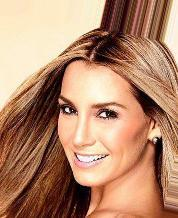

In [8]:
img

# Starting here, you’ll need to fill in the code cells on your own.

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as distribution of labels, etc.


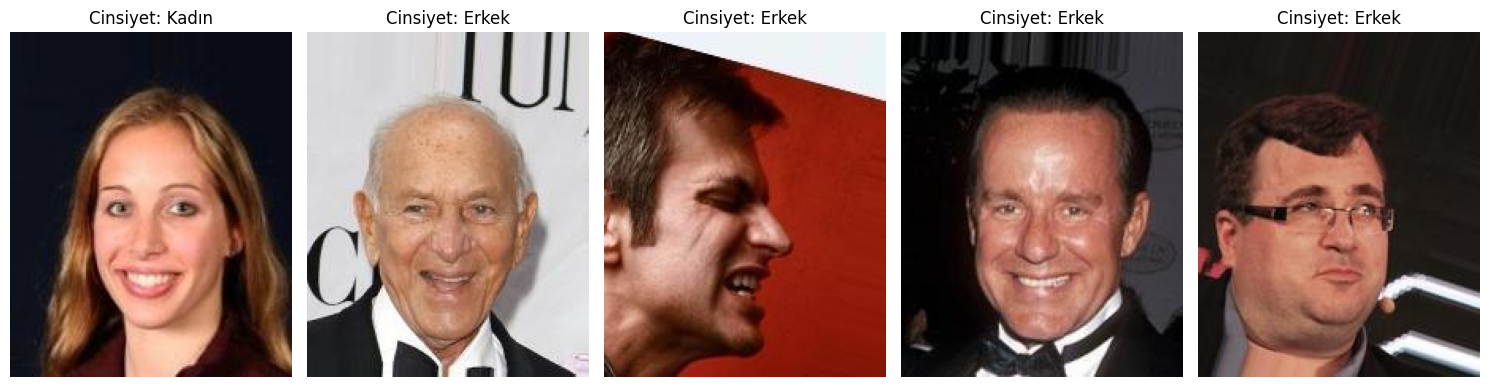

Toplam örnek sayısı: 30000

Cinsiyet Dağılımı:
Kadın: 0 örnek (0.00%)
Erkek: 12680 örnek (42.27%)


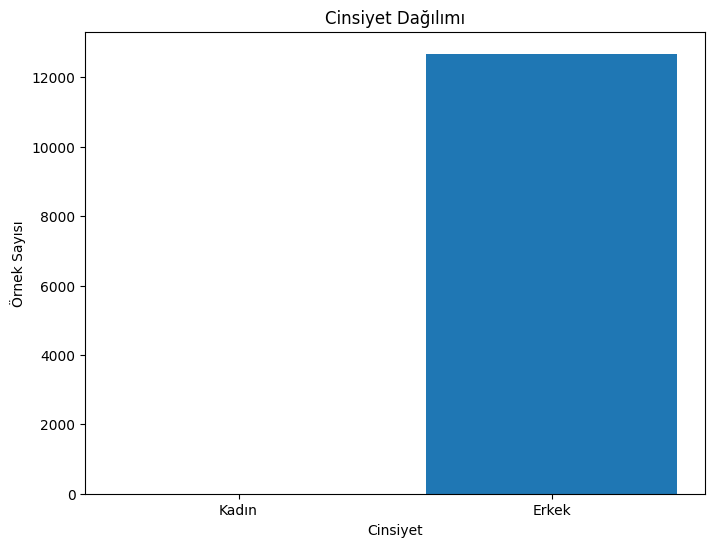

In [9]:
# 5 rasgele resmi etiketleriyle birlikte gösterme
import matplotlib.pyplot as plt
import numpy as np
import random

# Rasgele 5 örnek seç
random_indices = random.sample(range(len(gender_data)), 5)
sample_data = gender_data.iloc[random_indices]

plt.figure(figsize=(15, 10))
for i, (idx, row) in enumerate(sample_data.iterrows()):
    img_path = os.path.join("/content/data/CelebA30k/", row["filename"])
    img = Image.open(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Cinsiyet: {'Erkek' if row['Male'] == 1 else 'Kadın'}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Veri seti istatistiklerini gösterme
print(f"Toplam örnek sayısı: {len(gender_data)}")

# Cinsiyet dağılımı
gender_counts = gender_data['Male'].value_counts()
gender_percent = gender_data['Male'].value_counts(normalize=True) * 100

print("\nCinsiyet Dağılımı:")
print(f"Kadın: {gender_counts.get(0, 0)} örnek ({gender_percent.get(0, 0):.2f}%)")
print(f"Erkek: {gender_counts.get(1, 0)} örnek ({gender_percent.get(1, 0):.2f}%)")

# Görselleştirme
plt.figure(figsize=(8, 6))
plt.bar(['Kadın', 'Erkek'], [gender_counts.get(0, 0), gender_counts.get(1, 0)])
plt.title('Cinsiyet Dağılımı')
plt.xlabel('Cinsiyet')
plt.ylabel('Örnek Sayısı')
plt.show()


##4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [10]:
# Veri setini eğitim (%80), doğrulama (%10) ve test (%10) olarak bölme
from sklearn.model_selection import train_test_split

# İlk bölme: %80 eğitim, %20 geçici set
train_df, temp_df = train_test_split(gender_data, test_size=0.2, random_state=42, stratify=gender_data['Male'])

# İkinci bölme: geçici seti %10 doğrulama, %10 test olarak böl
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Male'])

print(f"Eğitim seti boyutu: {len(train_df)} ({len(train_df)/len(gender_data)*100:.2f}%)")
print(f"Doğrulama seti boyutu: {len(val_df)} ({len(val_df)/len(gender_data)*100:.2f}%)")
print(f"Test seti boyutu: {len(test_df)} ({len(test_df)/len(gender_data)*100:.2f}%)")

# Cinsiyet dağılımlarını kontrol et
print("\nEğitim seti cinsiyet dağılımı:")
print(train_df['Male'].value_counts(normalize=True) * 100)

print("\nDoğrulama seti cinsiyet dağılımı:")
print(val_df['Male'].value_counts(normalize=True) * 100)

print("\nTest seti cinsiyet dağılımı:")
print(test_df['Male'].value_counts(normalize=True) * 100)

Eğitim seti boyutu: 24000 (80.00%)
Doğrulama seti boyutu: 3000 (10.00%)
Test seti boyutu: 3000 (10.00%)

Eğitim seti cinsiyet dağılımı:
Male
-1    57.733333
 1    42.266667
Name: proportion, dtype: float64

Doğrulama seti cinsiyet dağılımı:
Male
-1    57.733333
 1    42.266667
Name: proportion, dtype: float64

Test seti cinsiyet dağılımı:
Male
-1    57.733333
 1    42.266667
Name: proportion, dtype: float64


## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Male`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5], [0.5]` for simplicity)
   - Add data augmentation (e.g., horizontal flip) for training
2. Write a custom `Dataset` class that reads images and labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size

In [19]:
# 5. Veri Hazırlama - Özel Dataset sınıfı ve veri dönüşümleri
# VGG-16 için görüntü dönüşümleri
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Özel Dataset sınıfı - ETİKETLERİ DÜZELT
class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_name).convert('RGB')

        # ETİKETLERİ NORMALLLEŞTIRME - Etiketler -1/1 ise 0/1 olarak dönüştür
        label_value = self.dataframe.iloc[idx]['Male']
        if label_value == -1:  # Eğer etiket -1 ise 0'a çevir (kadın)
            label_value = 0
        elif label_value == 1:  # Eğer etiket 1 ise 1 kalır (erkek)
            label_value = 1
        # Etiket 0 ise zaten 0'dır

        label = torch.tensor(label_value, dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Dataset ve DataLoader nesnelerini oluştur
img_dir = "/content/data/CelebA30k"
batch_size = 32

# Dataset nesneleri
train_dataset = CelebADataset(train_df, img_dir, train_transforms)
val_dataset = CelebADataset(val_df, img_dir, val_transforms)
test_dataset = CelebADataset(test_df, img_dir, val_transforms)

# DataLoader nesneleri
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# DataLoader'ı test et
images, labels = next(iter(train_loader))
print(f"Batch şekli: {images.shape}")
print(f"Etiket şekli: {labels.shape}")
print(f"Etiket değerleri: {labels.numpy()}")  # Etiketlerin doğru dönüştürüldüğünü kontrol et

Batch şekli: torch.Size([32, 3, 224, 224])
Etiket şekli: torch.Size([32])
Etiket değerleri: [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0.]


## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for gender classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with pretrained=True from torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [20]:
# 6. VGG-16 Transfer Learning - Düzeltilmiş versiyon
# VGG-16 modelini yükle (pretrained=True parametresi yerine weights kullanın)
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modelin mimarisini kontrol et
print(vgg16.classifier)

# Yeni sınıflandırıcı başlığı tanımla - Binary classification için 1 çıkış
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=1, bias=True)

# Modeli cihaza taşı
model = vgg16.to(device)
print("Model başarıyla oluşturuldu ve değiştirildi.")

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Model başarıyla oluşturuldu ve değiştirildi.


## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:
- Experiment with two different fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block and the classifier head, and train them.
- Choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- Use `nn.BCEWithLogitsLoss()` as the loss function.
  - Note: Since you are using nn.BCEWithLogitsLoss(), your model's output should not have a Sigmoid activation. This loss function applies the Sigmoid operation internally.
- Implement a training loop that includes validation after each epoch.
- Monitor both training and validation performance across epochs.

Hyperparameter Tuning:
- Try two different learning rates: 0.001 and 0.0001.
- The number of training epochs must be fixed to 10.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

Finally, you should report:
- Final training and validation accuracy for each configuration.
- A plot showing training and validation loss across epochs.
- A brief discussion comparing the results for different fine-tuning strategies and learning rates, identifying which combination performed best and why.



Eğitim: Sadece sınıflandırıcı başlığı, Öğrenme Oranı: 0.0001
Eğitilebilir parametre sayısı: 2
Epoch 1/10
----------
train Kaybı: 0.3143 Doğruluk: 0.8771
val Kaybı: 0.2456 Doğruluk: 0.9027

Epoch 2/10
----------
train Kaybı: 0.2468 Doğruluk: 0.9009
val Kaybı: 0.2297 Doğruluk: 0.9107

Epoch 3/10
----------
train Kaybı: 0.2355 Doğruluk: 0.9067
val Kaybı: 0.2219 Doğruluk: 0.9130

Epoch 4/10
----------
train Kaybı: 0.2313 Doğruluk: 0.9046
val Kaybı: 0.2169 Doğruluk: 0.9157

Epoch 5/10
----------
train Kaybı: 0.2295 Doğruluk: 0.9067
val Kaybı: 0.2150 Doğruluk: 0.9153

Epoch 6/10
----------
train Kaybı: 0.2266 Doğruluk: 0.9093
val Kaybı: 0.2130 Doğruluk: 0.9167

Epoch 7/10
----------
train Kaybı: 0.2248 Doğruluk: 0.9101
val Kaybı: 0.2115 Doğruluk: 0.9133

Epoch 8/10
----------
train Kaybı: 0.2243 Doğruluk: 0.9075
val Kaybı: 0.2101 Doğruluk: 0.9157

Epoch 9/10
----------
train Kaybı: 0.2239 Doğruluk: 0.9086
val Kaybı: 0.2087 Doğruluk: 0.9173

Epoch 10/10
----------
train Kaybı: 0.2188 Doğrulu

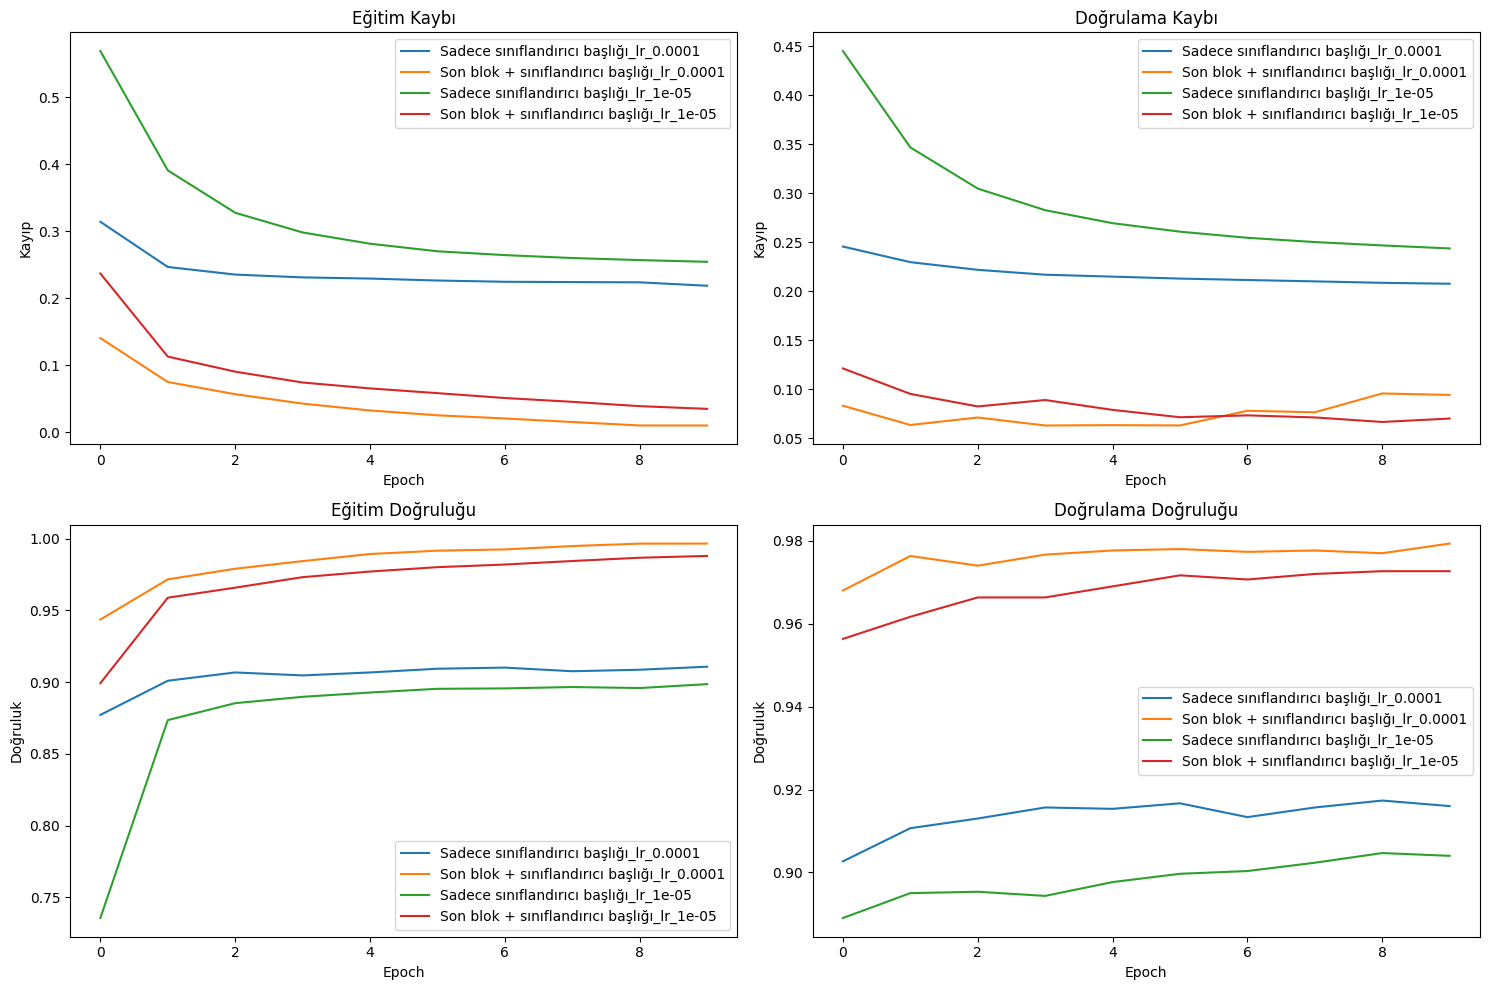

En iyi model: Son blok + sınıflandırıcı başlığı_lr_0.0001, Doğrulama doğruluğu: 0.9793


In [21]:
# 7. Fine-Tuning ve Model Eğitimi - Düzeltilmiş versiyon
import copy
import time

def set_parameter_requires_grad(model, feature_extracting, unfreeze_last_block=False):
    if feature_extracting:
        # Tüm parametreleri dondur
        for param in model.parameters():
            param.requires_grad = False

        # Sadece son bloğu eğitmek için (unfreeze_last_block=True ise)
        if unfreeze_last_block:
            # VGG-16'da son konvolüsyon bloğu features[-4:]
            for i, layer in enumerate(model.features):
                if i >= 24:  # VGG-16 son 4 katmanı (son blok)
                    for param in layer.parameters():
                        param.requires_grad = True

        # Sınıflandırıcı başlığını her zaman eğit
        for param in model.classifier[6].parameters():
            param.requires_grad = True

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    # Eğitim geçmişini takip etmek için sözlük
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    # En iyi modeli sakla
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Her epoch için hem eğitim hem de doğrulama
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Eğitim modu
            else:
                model.eval()   # Değerlendirme modu

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Veri üzerinde yineleme
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)  # [B] -> [B, 1] boyutuna getir

                # Gradyanları sıfırla
                optimizer.zero_grad()

                # İleri geçiş - eğitim sırasında gradyan hesapla
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs) > 0.5

                    # Eğitim aşamasında geri yayılım yap
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # İstatistikleri güncelle
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels).item()
                total_samples += batch_size

            # Epoch istatistiklerini hesapla
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            print(f'{phase} Kaybı: {epoch_loss:.4f} Doğruluk: {epoch_acc:.4f}')

            # Geçmişi kaydet
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

                # En iyi modeli kaydet
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # En iyi modeli yükle
    model.load_state_dict(best_model_wts)
    return model, history

# Sonuçları saklama sözlüğü
results = {}

# Deneyler için parametreler - öğrenme oranını düşür
learning_rates = [0.0001, 0.00001]  # Daha düşük öğrenme oranları
fine_tuning_strategies = [
    {"name": "Sadece sınıflandırıcı başlığı", "feature_extract": True, "unfreeze_last_block": False},
    {"name": "Son blok + sınıflandırıcı başlığı", "feature_extract": True, "unfreeze_last_block": True}
]

# Veri yükleyicileri sözlüğü
dataloaders = {'train': train_loader, 'val': val_loader}

# Kayıp fonksiyonu
criterion = nn.BCEWithLogitsLoss()

# Her bir konfigürasyon için eğitim yap
for lr in learning_rates:
    for strategy in fine_tuning_strategies:
        print(f"\n{'='*40}")
        print(f"Eğitim: {strategy['name']}, Öğrenme Oranı: {lr}")
        print(f"{'='*40}")

        # Modeli sıfırla (önceden eğitilmiş VGG-16)
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(4096, 1)
        model = model.to(device)

        # Fine-tuning stratejisini uygula
        set_parameter_requires_grad(model,
                                   feature_extracting=strategy['feature_extract'],
                                   unfreeze_last_block=strategy['unfreeze_last_block'])

        # Sadece eğitilebilir parametreler için optimizer
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Eğitilebilir parametrelerin sayısını kontrol et
        params_to_update = [p for p in model.parameters() if p.requires_grad]
        print(f"Eğitilebilir parametre sayısı: {len(params_to_update)}")

        # Modeli eğit
        start_time = time.time()
        trained_model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
        time_elapsed = time.time() - start_time

        print(f"Eğitim tamamlandı. Süre: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"En iyi doğrulama doğruluğu: {max(history['val_acc']):.4f}")

        # Sonuçları sakla
        config_name = f"{strategy['name']}_lr_{lr}"
        results[config_name] = {
            'model': trained_model,
            'history': history
        }

# Sonuçları görselleştir
plt.figure(figsize=(15, 10))

# Eğitim kayıpları
plt.subplot(2, 2, 1)
for config_name, result in results.items():
    plt.plot(result['history']['train_loss'], label=config_name)
plt.title('Eğitim Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğrulama kayıpları
plt.subplot(2, 2, 2)
for config_name, result in results.items():
    plt.plot(result['history']['val_loss'], label=config_name)
plt.title('Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Eğitim doğrulukları
plt.subplot(2, 2, 3)
for config_name, result in results.items():
    plt.plot(result['history']['train_acc'], label=config_name)
plt.title('Eğitim Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Doğrulama doğrulukları
plt.subplot(2, 2, 4)
for config_name, result in results.items():
    plt.plot(result['history']['val_acc'], label=config_name)
plt.title('Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

# En iyi modeli belirle
best_val_acc = 0
best_config = None

for config_name, result in results.items():
    val_acc = max(result['history']['val_acc'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = config_name

print(f"En iyi model: {best_config}, Doğrulama doğruluğu: {best_val_acc:.4f}")

## 8) Test your classifier on Test set

- Use your model to predict the labels of the test set and report the final accuracy.

En iyi model: Son blok + sınıflandırıcı başlığı_lr_0.0001, Doğrulama doğruluğu: 0.9793
Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Kadın       0.98      0.98      0.98      1732
       Erkek       0.97      0.98      0.97      1268

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



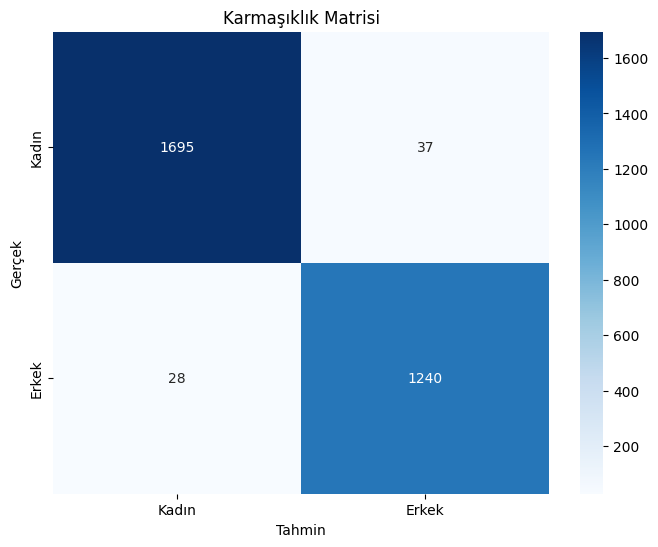

Test doğruluğu: 0.9783
En iyi model (Son blok + sınıflandırıcı başlığı_lr_0.0001) test doğruluğu: 0.9783


In [22]:
# 8. Test setinde değerlendirme - Düzeltilmiş versiyon
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_best_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).squeeze()

            # CPU'ya taşı ve listeye ekle
            if preds.dim() == 0:  # Tek eleman durumu
                preds = preds.unsqueeze(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Sınıflandırma raporu - 0.5 eşiği ile
    print("Sınıflandırma Raporu:")
    print(classification_report(all_labels, all_preds, target_names=['Kadın', 'Erkek'], zero_division=0))

    # Karmaşıklık matrisi
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Kadın', 'Erkek'], yticklabels=['Kadın', 'Erkek'])
    plt.title('Karmaşıklık Matrisi')
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()

    # Doğruluk hesapla
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum() if cm.sum() > 0 else 0
    print(f"Test doğruluğu: {accuracy:.4f}")

    return accuracy, cm

# En iyi modeli belirle
best_val_acc = 0
best_config = None

for config_name, result in results.items():
    val_acc = max(result['history']['val_acc'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = config_name

print(f"En iyi model: {best_config}, Doğrulama doğruluğu: {best_val_acc:.4f}")

# En iyi modeli test et
best_model = results[best_config]['model']
test_accuracy, test_cm = evaluate_best_model(best_model, test_loader)

print(f"En iyi model ({best_config}) test doğruluğu: {test_accuracy:.4f}")